In [1]:
from mftool import Mftool
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from yahooquery import Ticker
import datetime
from dateutil.relativedelta import relativedelta
from jugaad_data.nse import index_raw

%matplotlib inline

In [2]:
def fetch_index_data(index, start_date='1-1-2019', end_date='31-12-2023'):
    
    def convert_to_date(date_str):
        date_obj = datetime.datetime.strptime(date_str, '%d %b %Y')
        return date_obj

    # Get from and to dates
    from_date = datetime.datetime.strptime(start_date, '%d-%m-%Y').date()
    to_date = datetime.datetime.strptime(end_date, '%d-%m-%Y').date()
    
    # Pull data
    raw_index_data = index_raw(symbol=index, from_date=from_date, to_date=to_date)
    df = (pd.DataFrame(raw_index_data)\
            .assign(HistoricalDate=lambda x: x['HistoricalDate'].apply(convert_to_date),
                    CLOSE=lambda x: x['CLOSE'].astype(float),
                    INDEX_NAME = lambda x: x['INDEX_NAME'].str.upper())\
            .sort_values('HistoricalDate')\
            .drop_duplicates()\
            .loc[lambda x: x['INDEX_NAME'] == index]\
            .reset_index(drop=True)\
            .rename(columns={'HistoricalDate':'date'})
                       )
    df = df.loc[~df.duplicated(subset=['date'], keep='first')]
    return df


In [5]:
def fetch_mutual_fund_data(mutual_fund_code):
    mf = Mftool()
    
    df = (mf.get_scheme_historical_nav(mutual_fund_code,as_Dataframe=True).reset_index()\
          .assign(nav=lambda x: x['nav'].astype(float), 
                 date=lambda x: pd.to_datetime(x['date'], format='%d-%m-%Y'))\
          .sort_values('date')\
          .reset_index(drop=True)\
         )
    
    return df

In [3]:
def get_cumulative_returns(df, 
                         nav_col='CLOSE', 
                         date_col='date',
                         starting_date='1-1-2019', 
                         ending_date ='31-12-2023'):
    start_date = pd.to_datetime(starting_date, format='%d-%m-%Y')
    end_date = pd.to_datetime(ending_date, format='%d-%m-%Y')
    
    df = (df\
          .sort_values(date_col)\
          .query(f"{date_col} >= @start_date and {date_col} <=@end_date")\
          .assign(daily_returns=lambda x: x[nav_col].pct_change(),
                  cumulative_daily_returns=lambda x: (x['daily_returns'] + 1).cumprod())\
          .reset_index(drop=True)\
         )
    
    return df

### Pull Nifty Data

In [9]:
nifty_indices = ["NIFTY 500", "NIFTY 50", "NIFTY MIDCAP 150", "NIFTY SMALLCAP 250", "NIFTY 200", "NIFTY 100"]
nifty_indices_df_dict = {index: fetch_index_data(index) for index in nifty_indices}

### Pull Mutual Funds Data

In [6]:
# Fetch data for these funds
mutual_funds = {'120819': 'quant Absolute Fund-Growth Option-Direct Plan',
 '120828': 'quant Small Cap Fund - Growth Option - Direct Plan',
 '119063': 'HDFC Index Fund-NIFTY 50 Plan - Direct Plan',
 '118955': 'HDFC Flexi Cap Fund - Growth Option - Direct Plan',
 '118269': 'CANARA ROBECO BLUE CHIP EQUITY FUND - DIRECT PLAN - GROWTH OPTION',
 '122639': 'Parag Parikh Flexi Cap Fund - Direct Plan - Growth',
 '125307': 'PGIM India Midcap Opportunities Fund - Direct Plan - Growth Option', 
 '146271': 'Nippon India ETF Nifty Midcap 150', 
 '147704': 'Motilal Oswal Large and Midcap Fund - Direct Plan Growth',
}

mf_data_dict = dict()
for mutual_fund_code, mutual_fund_desc in mutual_funds.items():
    print(mutual_fund_desc)
    mf_data_dict[mutual_fund_desc] = fetch_mutual_fund_data(mutual_fund_code)

quant Absolute Fund-Growth Option-Direct Plan
quant Small Cap Fund - Growth Option - Direct Plan
HDFC Index Fund-NIFTY 50 Plan - Direct Plan
HDFC Flexi Cap Fund - Growth Option - Direct Plan
CANARA ROBECO BLUE CHIP EQUITY FUND - DIRECT PLAN - GROWTH OPTION
Parag Parikh Flexi Cap Fund - Direct Plan - Growth
PGIM India Midcap Opportunities Fund - Direct Plan - Growth Option
Nippon India ETF Nifty Midcap 150
Motilal Oswal Large and Midcap Fund - Direct Plan Growth


### Calculate cumulative returns and growth %

In [10]:
time_periods = {
    1: '1-1-2023', 
    2: '1-1-2022', 
    3: '1-1-2021',
    4: '1-1-2020',
    5: '1-1-2019',
}
results = []
time_period_dataframes = {time_period: dict() for time_period in time_periods}

# Mutual Funds data
mutual_funds_subset = ['quant Absolute Fund-Growth Option-Direct Plan',
 'quant Small Cap Fund - Growth Option - Direct Plan',
 'HDFC Index Fund-NIFTY 50 Plan - Direct Plan',
 'HDFC Flexi Cap Fund - Growth Option - Direct Plan',
 'CANARA ROBECO BLUE CHIP EQUITY FUND - DIRECT PLAN - GROWTH OPTION',
 'Parag Parikh Flexi Cap Fund - Direct Plan - Growth',
 'PGIM India Midcap Opportunities Fund - Direct Plan - Growth Option',
 'Nippon India ETF Nifty Midcap 150',
 'Motilal Oswal Large and Midcap Fund - Direct Plan Growth']

for instrument_desc in mutual_funds_subset: 
    for time_period, starting_date in time_periods.items():
        n_years = time_period
        mutual_fund_data = mf_data_dict[instrument_desc].copy(deep=True)
        mf_with_cumulative = get_cumulative_returns(mutual_fund_data, 
                                                           nav_col='nav', 
                                                           date_col='date',
                                                           starting_date=starting_date, 
                                                           ending_date ='31-12-2023')
        absolute_returns_prcnt = (mf_with_cumulative['cumulative_daily_returns'].values[-1] - 1) * 100
        cagr = ((mf_with_cumulative['nav'].iloc[-1]/mf_with_cumulative['nav'].iloc[0]) ** (1/n_years) - 1) * 100

        time_period_dataframes[time_period][instrument_desc] = mf_with_cumulative
        results += [(instrument_desc, time_period, absolute_returns_prcnt, cagr)]
        

## Indices cumulative returns and growth 
nifty_indices = ["NIFTY 500", "NIFTY 50", "NIFTY MIDCAP 150", "NIFTY SMALLCAP 250", "NIFTY 200", "NIFTY 100"]
nifty_indices_results = []
time_period_nifty_dataframes = {time_period: dict() for time_period in time_periods}


for index in nifty_indices:
    print(index)
    for time_period, starting_date in time_periods.items():
        n_years = time_period
        index_df = nifty_indices_df_dict[index].copy(deep=True)
        index_with_cumulative = get_cumulative_returns(index_df, 
                                                           nav_col='CLOSE', 
                                                           date_col='date',
                                                           starting_date=starting_date, 
                                                           ending_date ='31-12-2023')
        absolute_returns_prcnt = (index_with_cumulative['cumulative_daily_returns'].values[-1] - 1) * 100
        cagr = ((index_with_cumulative['CLOSE'].iloc[-1]/index_with_cumulative['CLOSE'].iloc[0]) ** (1/n_years) - 1) * 100

        time_period_nifty_dataframes[time_period][index] = index_with_cumulative
        nifty_indices_results += [(index, time_period, absolute_returns_prcnt, cagr)]

NIFTY 500
NIFTY 50
NIFTY MIDCAP 150
NIFTY SMALLCAP 250
NIFTY 200
NIFTY 100


### Calculate returns or abs growth for each year 

In [66]:
# time_periods = {
#     1: ('1-1-2023', '31-12-2023'), 
#     2: ('1-1-2022', '31-12-2022'),
#     3: ('1-1-2021', '31-12-2021'),
#     4: ('1-1-2020', '31-12-2020'),
#     5: ('1-1-2019', '31-12-2019'),
# }

time_periods = {
    2023: ('1-1-2023', '31-12-2023'), 
    2022: ('1-1-2022', '31-12-2022'),
    2021: ('1-1-2021', '31-12-2021'),
    2020: ('1-1-2020', '31-12-2020'),
    2019: ('1-1-2019', '31-12-2019'),
}

mf_results = []
time_period_dataframes = {time_period: dict() for time_period in time_periods}

# Mutual Funds data
mutual_funds_subset = ['quant Absolute Fund-Growth Option-Direct Plan',
 'quant Small Cap Fund - Growth Option - Direct Plan',
 'HDFC Index Fund-NIFTY 50 Plan - Direct Plan',
 'HDFC Flexi Cap Fund - Growth Option - Direct Plan',
 'CANARA ROBECO BLUE CHIP EQUITY FUND - DIRECT PLAN - GROWTH OPTION',
 'Parag Parikh Flexi Cap Fund - Direct Plan - Growth',
 'PGIM India Midcap Opportunities Fund - Direct Plan - Growth Option',
 'Nippon India ETF Nifty Midcap 150',
 'Motilal Oswal Large and Midcap Fund - Direct Plan Growth']

for instrument_desc in mutual_funds_subset: 
    for time_period, (starting_date, ending_date) in time_periods.items():
        n_years = time_period
        mutual_fund_data = mf_data_dict[instrument_desc].copy(deep=True)
        mf_with_cumulative = get_cumulative_returns(mutual_fund_data, 
                                                           nav_col='nav', 
                                                           date_col='date',
                                                           starting_date=starting_date, 
                                                           ending_date =ending_date)
        absolute_returns_prcnt = (mf_with_cumulative['cumulative_daily_returns'].values[-1] - 1) * 100

        time_period_dataframes[time_period][instrument_desc] = mf_with_cumulative
        mf_results += [(instrument_desc, time_period, absolute_returns_prcnt)]
        

## Indices cumulative returns and growth 
nifty_indices = ["NIFTY 500", "NIFTY 50", "NIFTY MIDCAP 150", "NIFTY SMALLCAP 250", "NIFTY 200", "NIFTY 100"]
nifty_indices_results = []
time_period_nifty_dataframes = {time_period: dict() for time_period in time_periods}


for index in nifty_indices:
    print(index)
    for time_period, (starting_date, ending_date) in time_periods.items():
        n_years = time_period
        index_df = nifty_indices_df_dict[index].copy(deep=True)
        index_with_cumulative = get_cumulative_returns(index_df, 
                                                           nav_col='CLOSE', 
                                                           date_col='date',
                                                           starting_date=starting_date, 
                                                           ending_date=ending_date)
        absolute_returns_prcnt = (index_with_cumulative['cumulative_daily_returns'].values[-1] - 1) * 100

        time_period_nifty_dataframes[time_period][index] = index_with_cumulative
        nifty_indices_results += [(index, time_period, absolute_returns_prcnt)]

NIFTY 500
NIFTY 50
NIFTY MIDCAP 150
NIFTY SMALLCAP 250
NIFTY 200
NIFTY 100


In [89]:
mf_result_df = pd.DataFrame(mf_results, columns=['Fund', 'Years', 'Abs_returns_prcnt',]).\
pivot(index='Fund', columns='Years', values=['Abs_returns_prcnt',])
mf_result_df.columns = [f'{x}_{y}' for x, y in mf_result_df.columns]
mf_result_df = mf_result_df.applymap(lambda x: f"{x:.2f}%").reset_index()
mf_result_df

,Fund,Abs_returns_prcnt_2019,Abs_returns_prcnt_2020,Abs_returns_prcnt_2021,Abs_returns_prcnt_2022,Abs_returns_prcnt_2023
0,CANARA ROBECO BLUE CHIP EQUITY FUND - DIRECT P...,16.83%,24.55%,26.17%,0.82%,23.19%
1,HDFC Flexi Cap Fund - Growth Option - Direct Plan,6.68%,6.61%,36.17%,17.29%,30.67%
2,HDFC Index Fund-NIFTY 50 Plan - Direct Plan,12.70%,15.20%,24.91%,3.77%,20.41%
3,Motilal Oswal Large and Midcap Fund - Direct P...,5.02%,14.33%,42.31%,1.90%,39.75%
4,Nippon India ETF Nifty Midcap 150,4.19%,24.90%,45.93%,2.47%,43.27%
5,PGIM India Midcap Opportunities Fund - Direct ...,4.85%,51.13%,65.12%,-0.81%,21.68%
6,Parag Parikh Flexi Cap Fund - Direct Plan - Gr...,14.93%,33.28%,46.76%,-6.51%,37.49%
7,quant Absolute Fund-Growth Option-Direct Plan,6.93%,37.21%,43.74%,13.93%,16.76%
8,quant Small Cap Fund - Growth Option - Direct ...,-23.43%,74.95%,89.90%,9.17%,45.56%


In [82]:
nifty_result_df = pd.DataFrame(nifty_indices_results, columns=['Fund', 'Years', 'Abs_returns_prcnt']).\
pivot(index='Fund', columns='Years', values=['Abs_returns_prcnt'])
nifty_result_df.columns = [f'{x}_{y}' for x, y in nifty_result_df.columns]
# nifty_result_df = nifty_result_df.applymap(lambda x: f"{x:.2f}%").reset_index()
nifty_result_df

,Abs_returns_prcnt_2019,Abs_returns_prcnt_2020,Abs_returns_prcnt_2021,Abs_returns_prcnt_2022,Abs_returns_prcnt_2023
Fund,,,,,
NIFTY 100,10.036506,14.754399,24.624139,2.152568,19.550787
NIFTY 200,8.335210,15.492598,26.922071,2.208494,22.906326
NIFTY 50,11.533808,14.769136,23.793915,2.721027,19.420029
NIFTY 500,7.334826,16.481183,29.558482,1.606422,25.158387
NIFTY MIDCAP 150,-0.316635,23.943285,45.141639,1.818657,42.661838
NIFTY SMALLCAP 250,-8.596870,24.189098,60.100225,-4.867379,46.986224


In [77]:
returns

array([[10.04,  8.34, 11.53],
       [14.75, 15.49, 14.77],
       [24.62, 26.92, 23.79],
       [ 2.15,  2.21,  2.72],
       [19.55, 22.91, 19.42]])

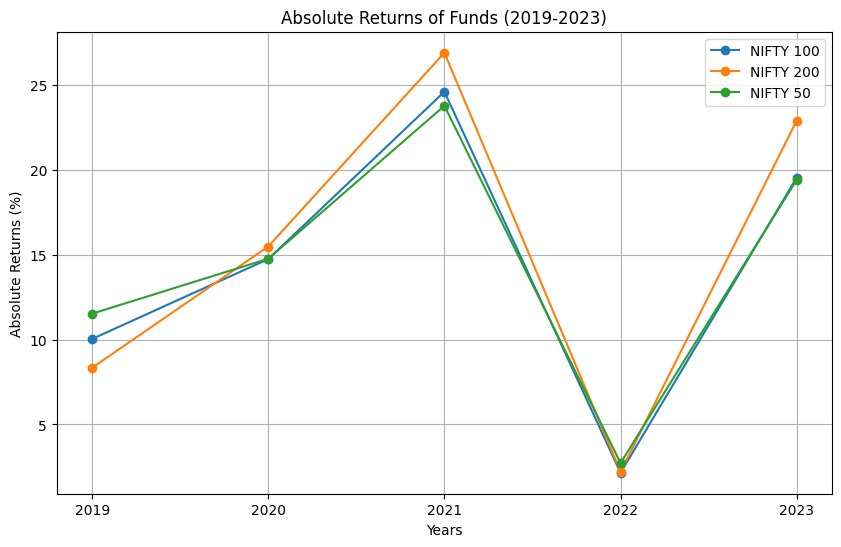

In [76]:
import matplotlib.pyplot as plt
import numpy as np

# Data
funds = ["NIFTY 100", "NIFTY 200", "NIFTY 50"]
returns_2019 = [10.04, 8.34, 11.53]
returns_2020 = [14.75, 15.49, 14.77]
returns_2021 = [24.62, 26.92, 23.79]
returns_2022 = [2.15, 2.21, 2.72]
returns_2023 = [19.55, 22.91, 19.42]

# Transpose the data for inverted axes
years = ['2019', '2020', '2021', '2022', '2023']
returns = np.array([returns_2019, returns_2020, returns_2021, returns_2022, returns_2023])

# Plotting the data with inverted axes
plt.figure(figsize=(10, 6))

for i, fund in enumerate(funds):
    plt.plot(years, returns[:, i], marker='o', label=fund)

# Adding labels and title
plt.xlabel('Years')
plt.ylabel('Absolute Returns (%)')
plt.title('Absolute Returns of Funds (2019-2023)')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


In [45]:
index_with_cumulative

,Index Name,INDEX_NAME,date,OPEN,HIGH,LOW,CLOSE,daily_returns,cumulative_daily_returns
0,Nifty 100,NIFTY 100,2019-01-01,11130.55,11161,11051.5,11148.80,NaN,NaN
1,Nifty 100,NIFTY 100,2019-01-02,11110.15,11139.45,10977.65,11032.00,-0.010476,0.989524
2,Nifty 100,NIFTY 100,2019-01-03,11035.7,11059.55,10904.85,10914.80,-0.010624,0.979011
3,Nifty 100,NIFTY 100,2019-01-04,10940.9,10981.45,10869.45,10966.15,0.004705,0.983617
4,Nifty 100,NIFTY 100,2019-01-07,11044.05,11070.2,10983.55,11005.10,0.003552,0.987111
...,...,...,...,...,...,...,...,...,...
1234,Nifty 100,NIFTY 100,2023-12-22,21461.25,21544.2,21382.2,21508.85,0.004985,1.929252
1235,Nifty 100,NIFTY 100,2023-12-26,21539.4,21647.05,21504.6,21617.05,0.005030,1.938958
1236,Nifty 100,NIFTY 100,2023-12-27,21683.9,21834.7,21678.4,21815.45,0.009178,1.956753
1237,Nifty 100,NIFTY 100,2023-12-28,21879.85,21951.9,21836.95,21931.75,0.005331,1.967185


### Mapping funds to their benchmarks

In [22]:
nifty_indices = ["NIFTY 500", "NIFTY 50", "NIFTY MIDCAP 150", "NIFTY SMALLCAP 250", "NIFTY 200"]

funds_benchmark_mapping = {'quant Absolute Fund-Growth Option-Direct Plan': "NIFTY 500",
 'quant Small Cap Fund - Growth Option - Direct Plan': "NIFTY SMALLCAP 250",
 'HDFC Index Fund-NIFTY 50 Plan - Direct Plan': "NIFTY 50",
 'HDFC Flexi Cap Fund - Growth Option - Direct Plan': "NIFTY 500",
 'CANARA ROBECO BLUE CHIP EQUITY FUND - DIRECT PLAN - GROWTH OPTION': "NIFTY 100",
 'Parag Parikh Flexi Cap Fund - Direct Plan - Growth': "NIFTY 500",
 'PGIM India Midcap Opportunities Fund - Direct Plan - Growth Option': "NIFTY MIDCAP 150",
 'Nippon India ETF Nifty Midcap 150': "NIFTY MIDCAP 150",
 'Motilal Oswal Large and Midcap Fund - Direct Plan Growth': "NIFTY 200"}

### Yearly returns comparison - funds vs benchmark

The returns are calculated at a yearly basis

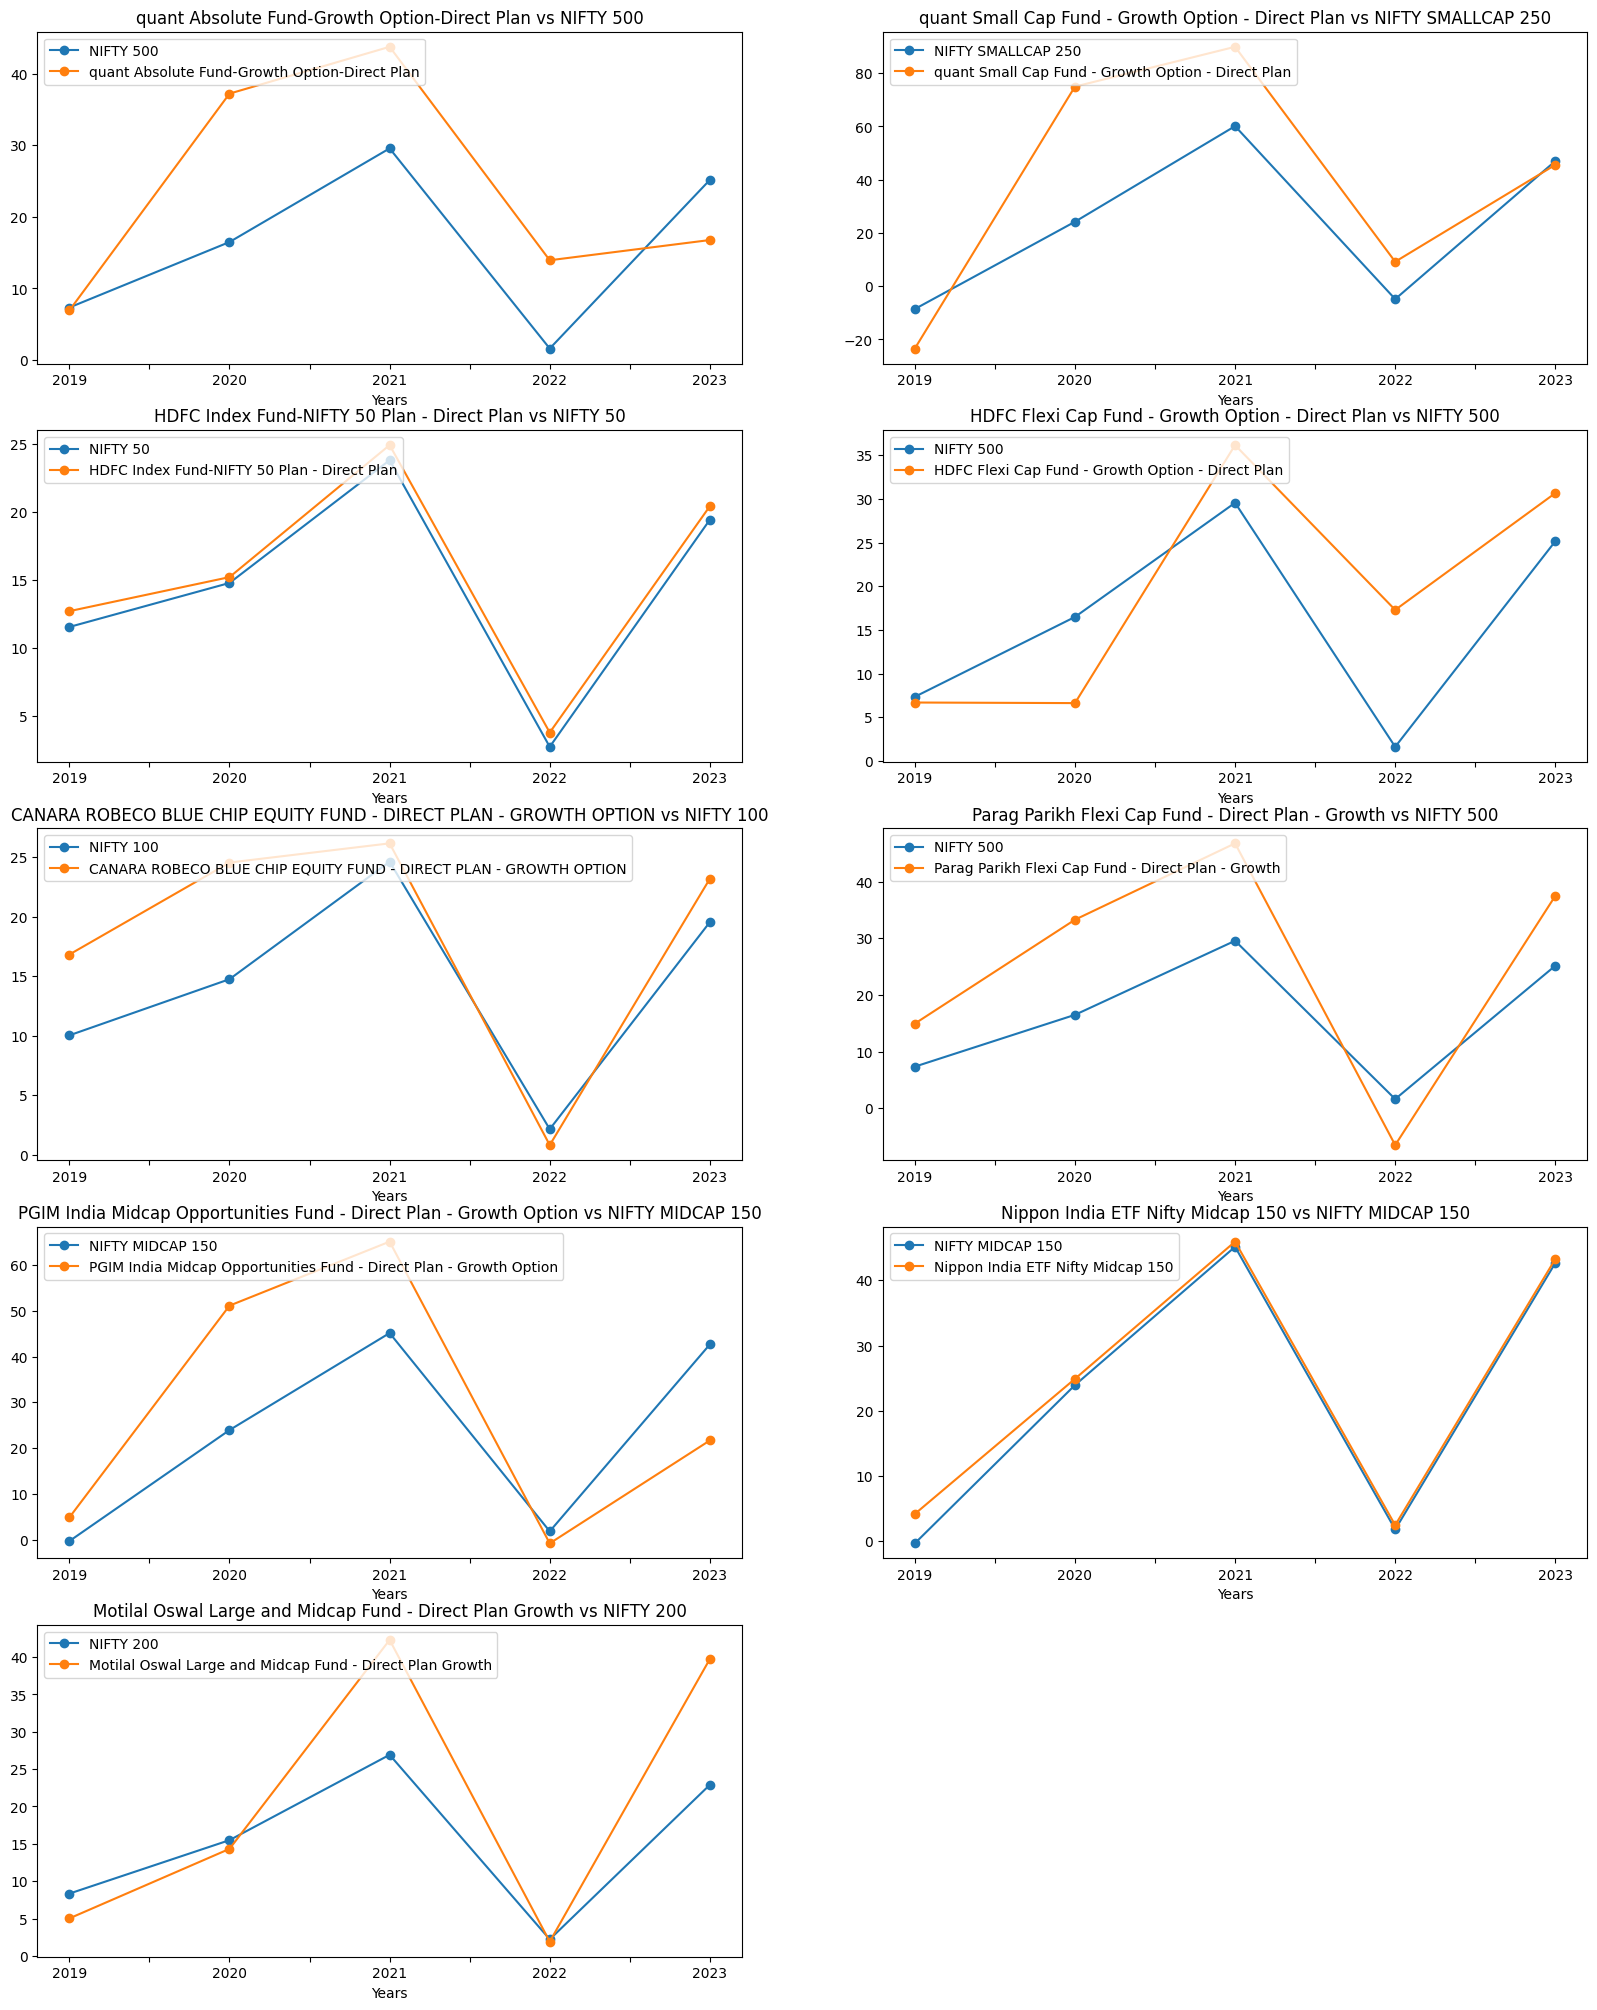

In [111]:
nifty_results_long = pd.DataFrame(nifty_indices_results, columns=['Fund', 'Years', 'Abs_returns_prcnt'])
funds_results_long = pd.DataFrame(mf_results, columns=['Fund', 'Years', 'Abs_returns_prcnt',])
plt.rcParams["figure.figsize"] = [4,3]
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20, 25))

# Flatten the axes array for easy indexing
axes = axes.flatten()

for ax in axes:
    ax.set_axis_off()

ax = axes[i]

ax.set_axis_on()

def df_process(df):
    df = df.sort_values('Years')
    df['Years'] = df['Years'].astype(str)
    return df

for idx, (fund, index) in enumerate(funds_benchmark_mapping.items()):
    index_df = nifty_results_long.loc[nifty_results_long['Fund'] == index].copy()
    fund_df = funds_results_long.loc[funds_results_long['Fund'] == fund].copy()
    
    index_df = df_process(index_df)
    fund_df = df_process(fund_df)

    ax = axes[idx]
    index_df.plot(ax=ax, y='Abs_returns_prcnt', x='Years', label=index, marker='o',)
    fund_df.plot(ax = ax, y='Abs_returns_prcnt', x='Years', label=fund, marker='o',)
    ax.legend(loc='upper left')
    ax.set_title(f'{fund} vs {index}')
    ax.set_axis_on()
    
plt.show()

### Plotting funds vs benchmarks - Only 1 time period

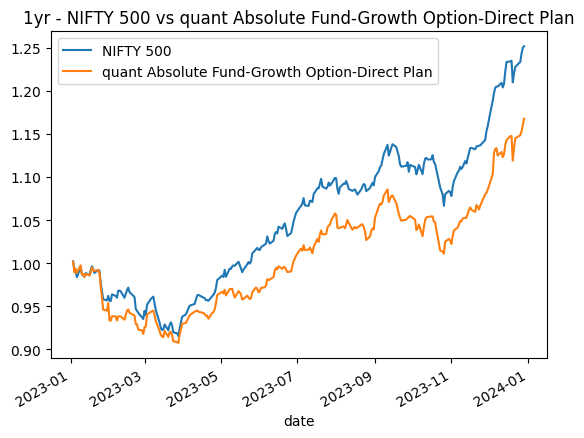

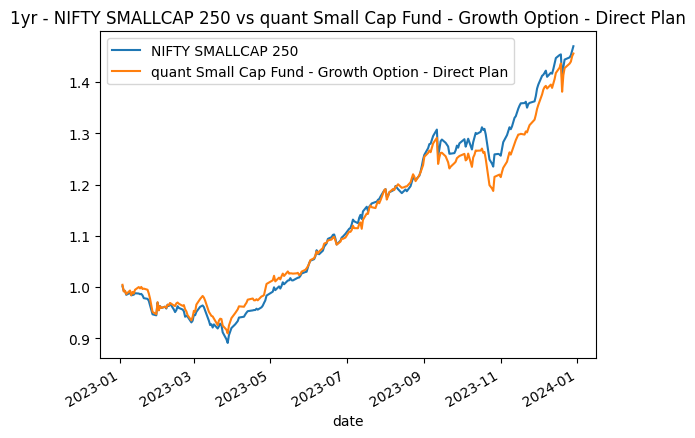

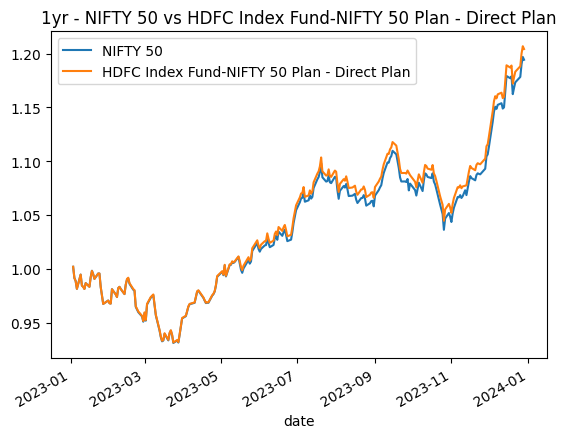

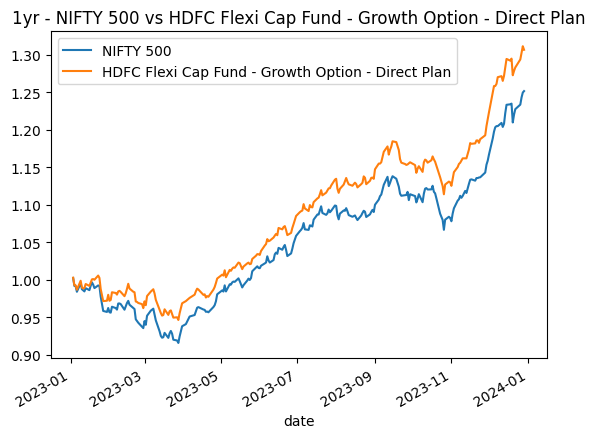

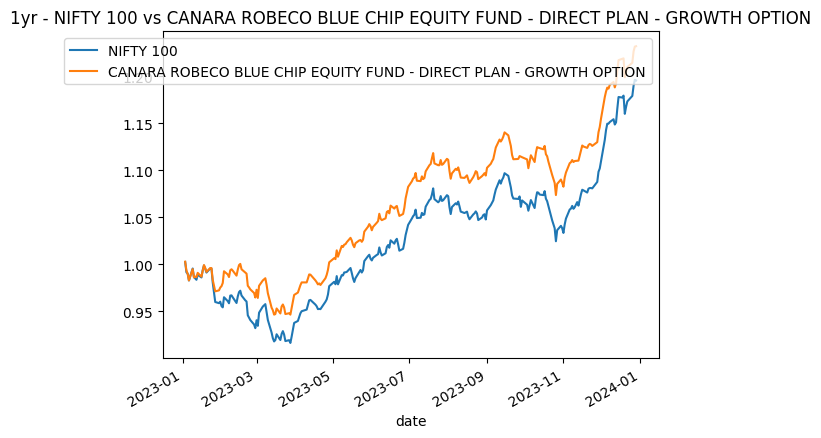

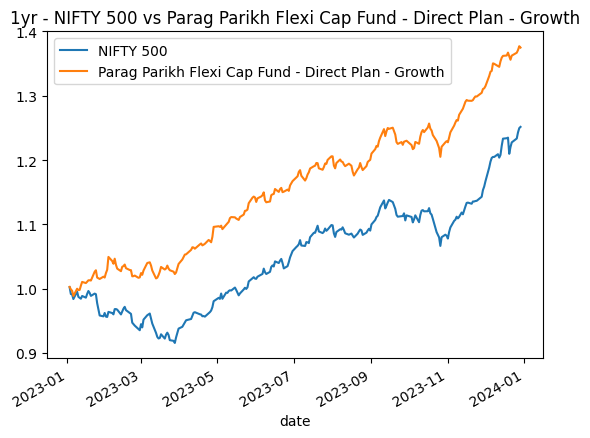

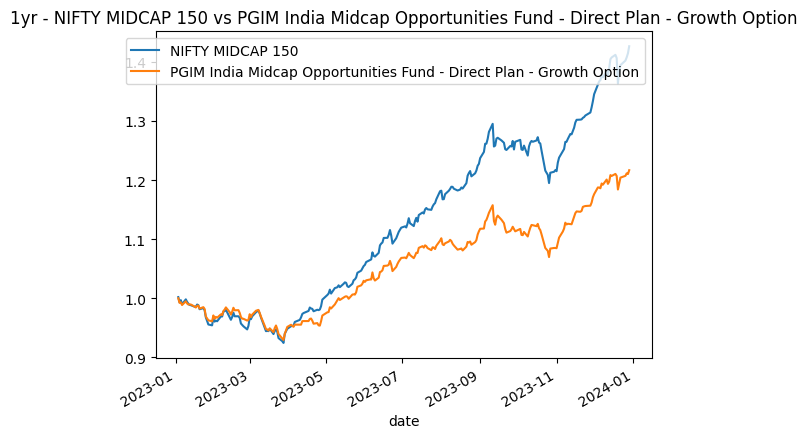

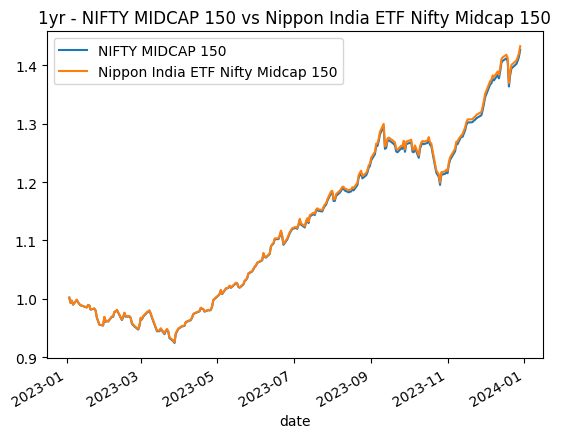

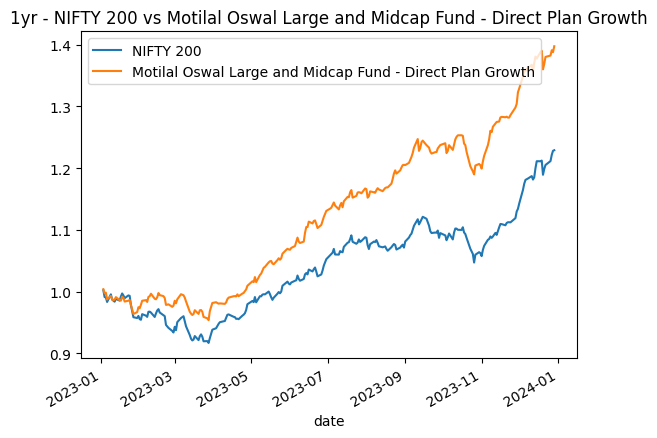

In [35]:
time_period = 1
for fund, index in funds_benchmark_mapping.items():
    index_df = time_period_nifty_dataframes[time_period][index].copy()
    fund_df = time_period_dataframes[time_period][fund].copy()

    ax = index_df.plot(y='cumulative_daily_returns', x='date', label=index)
    fund_df.plot(ax = ax, y='cumulative_daily_returns', x='date', label=fund)
    plt.title(f'{time_period}yr - {index} vs {fund}')
    plt.show()


###  Plotting funds vs benchmarks -Multiple time period subplots

In [36]:
# for time_period in list(time_periods):
#     index_df = time_period_nifty_dataframes[time_period][index].copy()
#     fund_df = time_period_dataframes[time_period][fund].copy()

#     ax = index_df.plot(y='cumulative_daily_returns', x='date', label=index)
#     fund_df.plot(ax = ax, y='cumulative_daily_returns', x='date', label=fund)
#     plt.title(f'{time_period}yr - {index} vs {fund}')
#     plt.show()

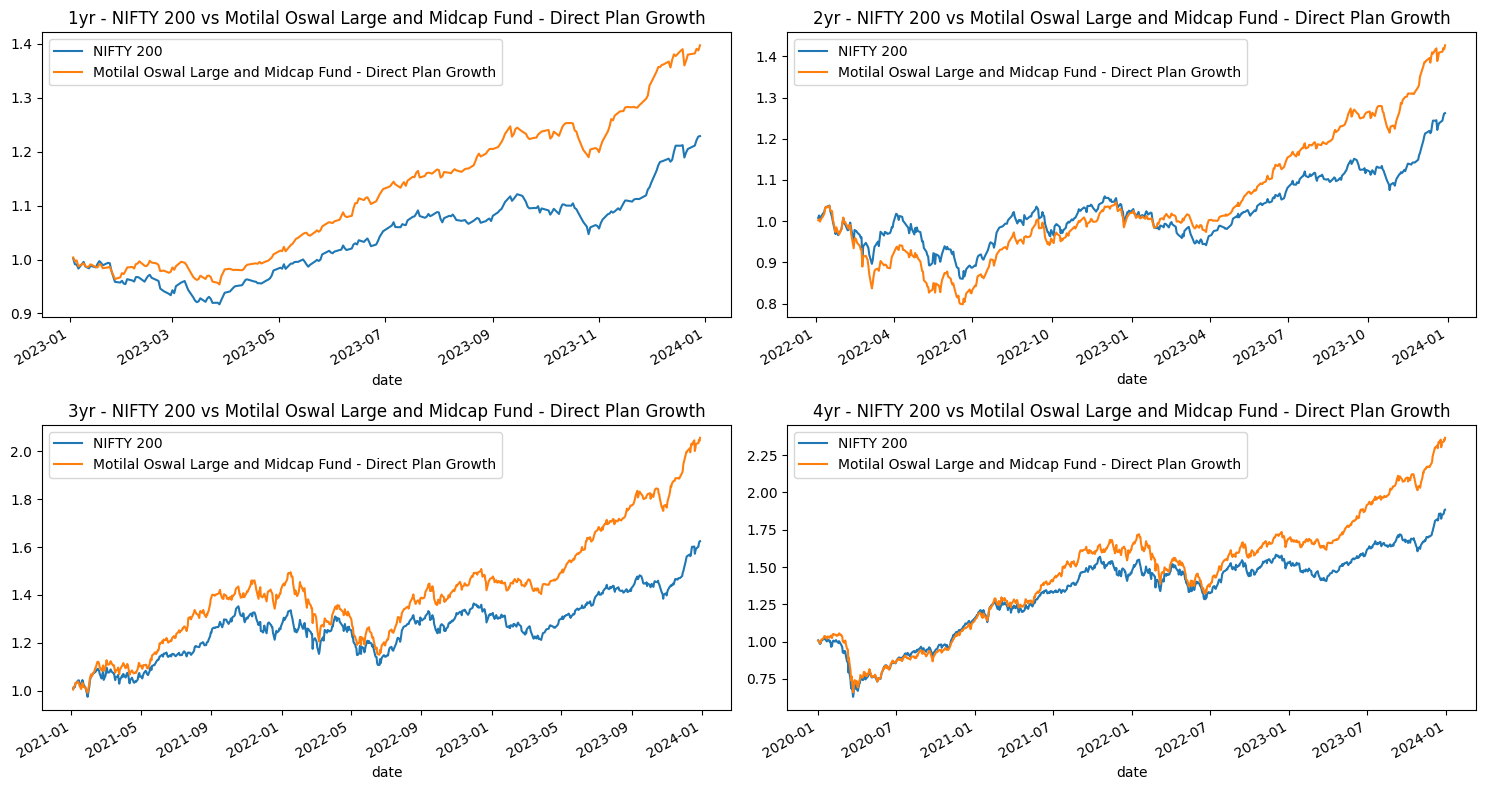

In [37]:
# Create subplots with 3 columns and 2 rows
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))

# Flatten the axes array for easy indexing
axes = axes.flatten()

for i, time_period in enumerate([1,2,3,4]):
    index_df = time_period_nifty_dataframes[time_period][index].copy()
    fund_df = time_period_dataframes[time_period][fund].copy()

    # Use the current subplot
    ax = axes[i]

    # Plot on the current subplot
    index_df.plot(ax=ax, y='cumulative_daily_returns', x='date', label=index)
    fund_df.plot(ax=ax, y='cumulative_daily_returns', x='date', label=fund)

    ax.set_title(f'{time_period}yr - {index} vs {fund}')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [ ]:
 # Flatten the axes array for easy indexing
    axes = axes.flatten()
    
    for ax in axes:
        ax.set_axis_off()
        
    ax = axes[i]
        ax.set_axis_on()

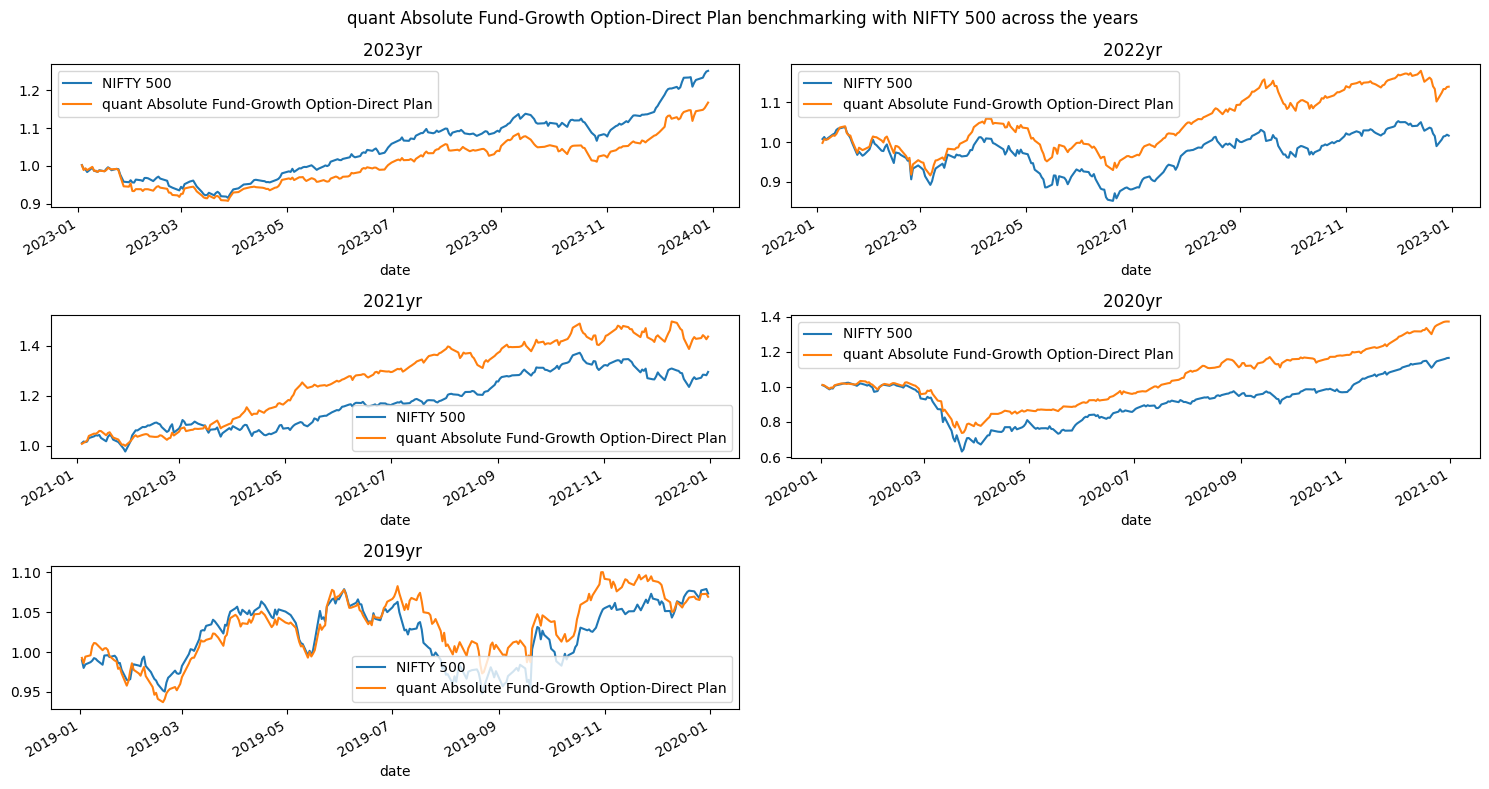

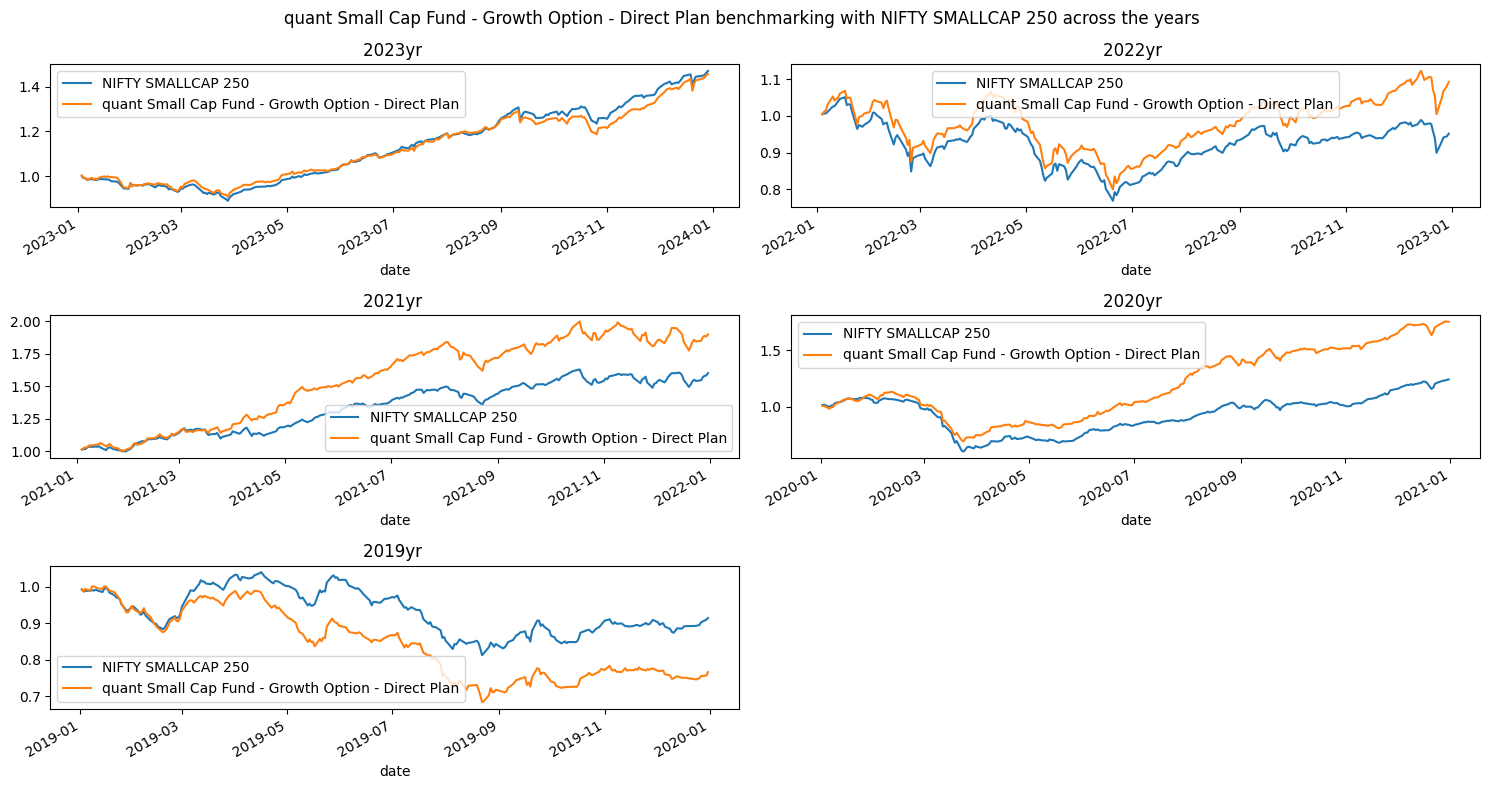

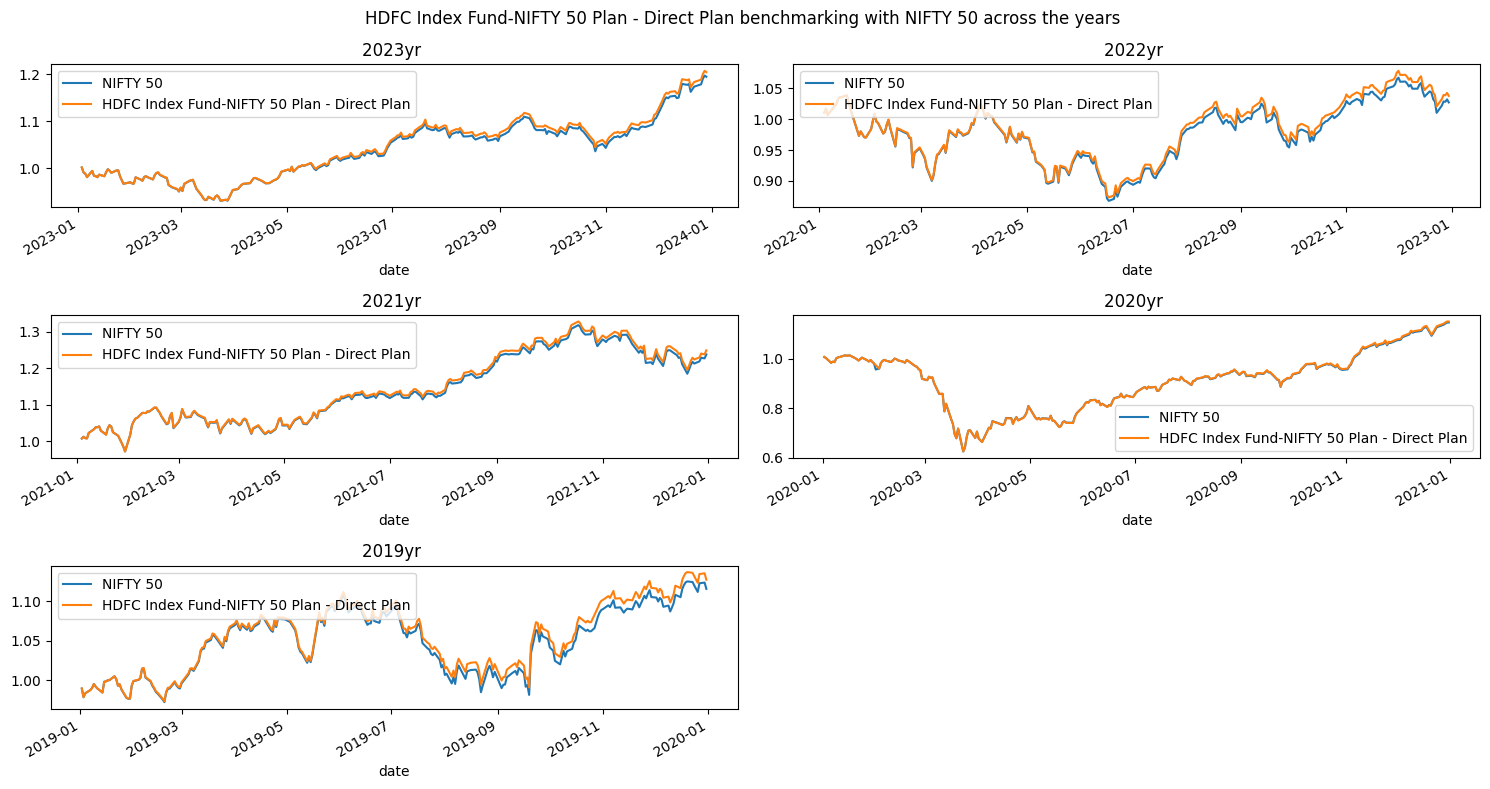

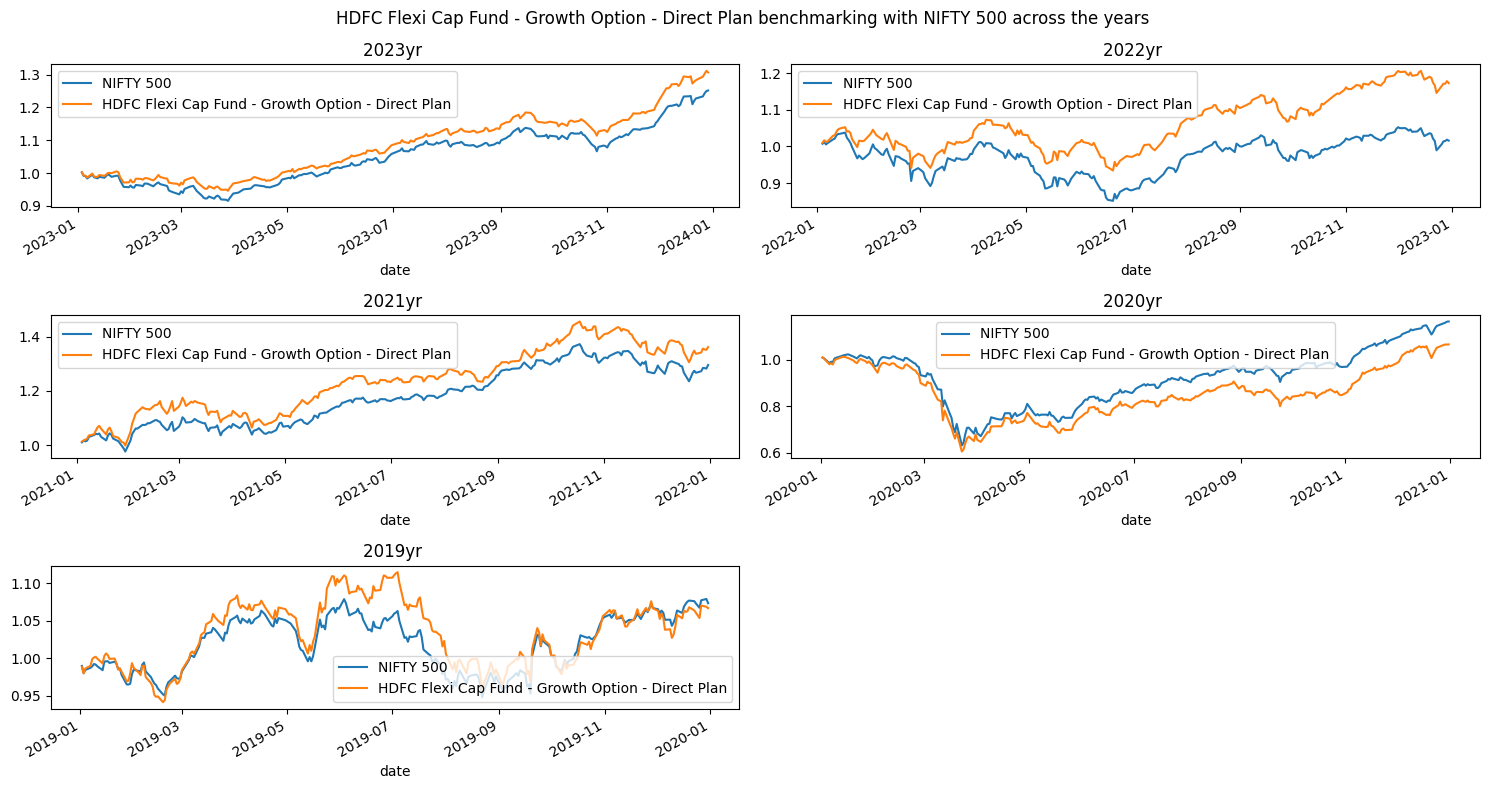

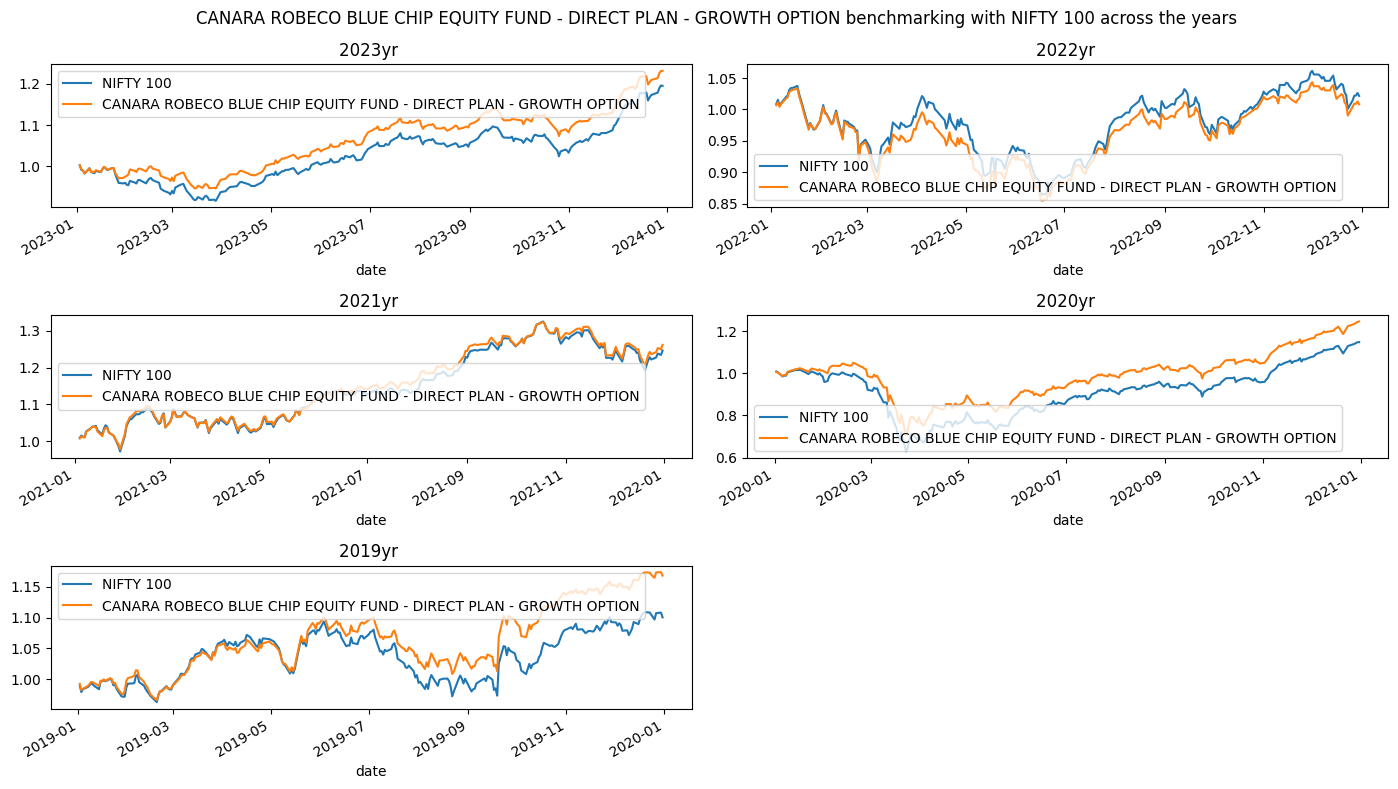

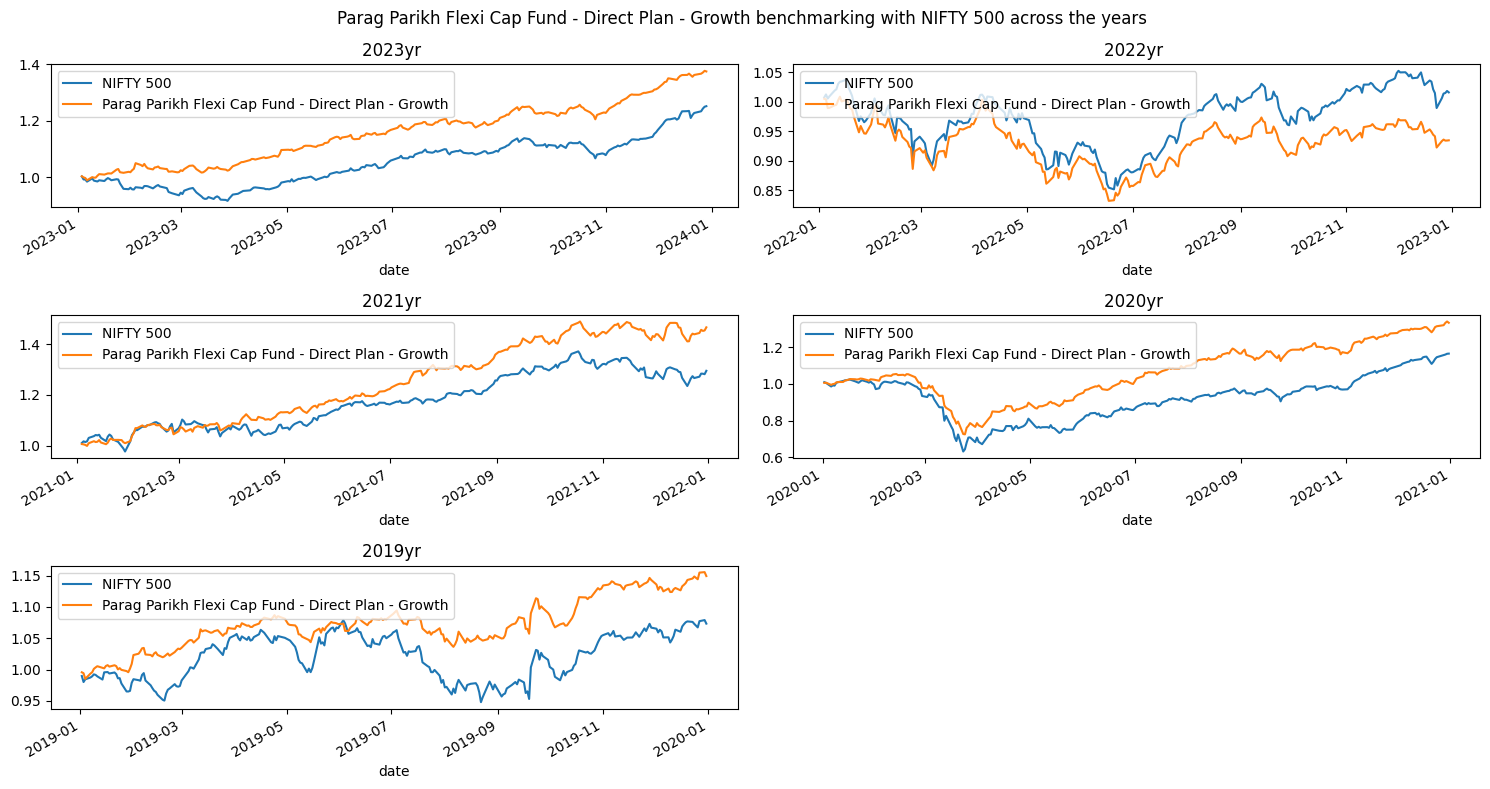

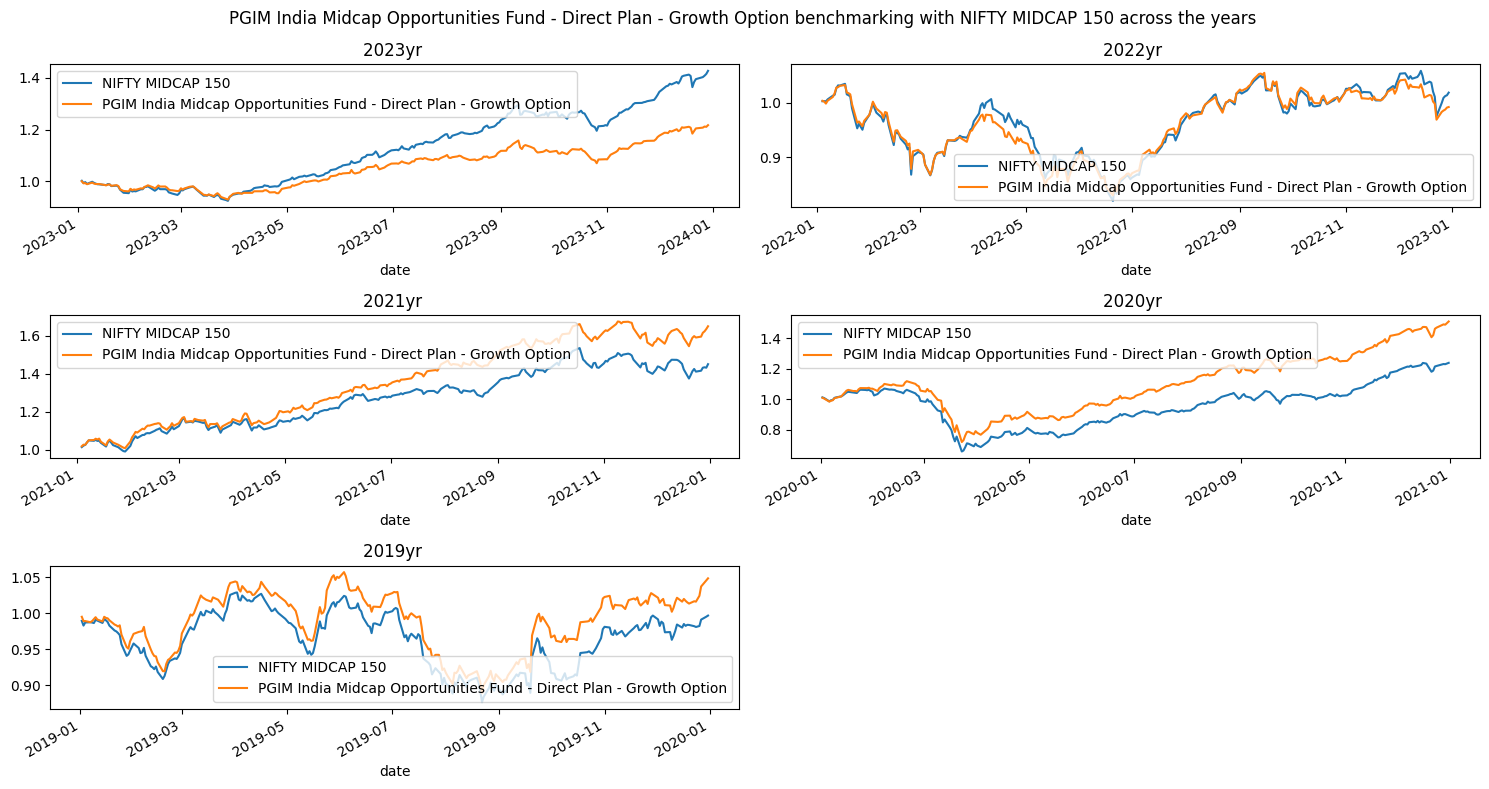

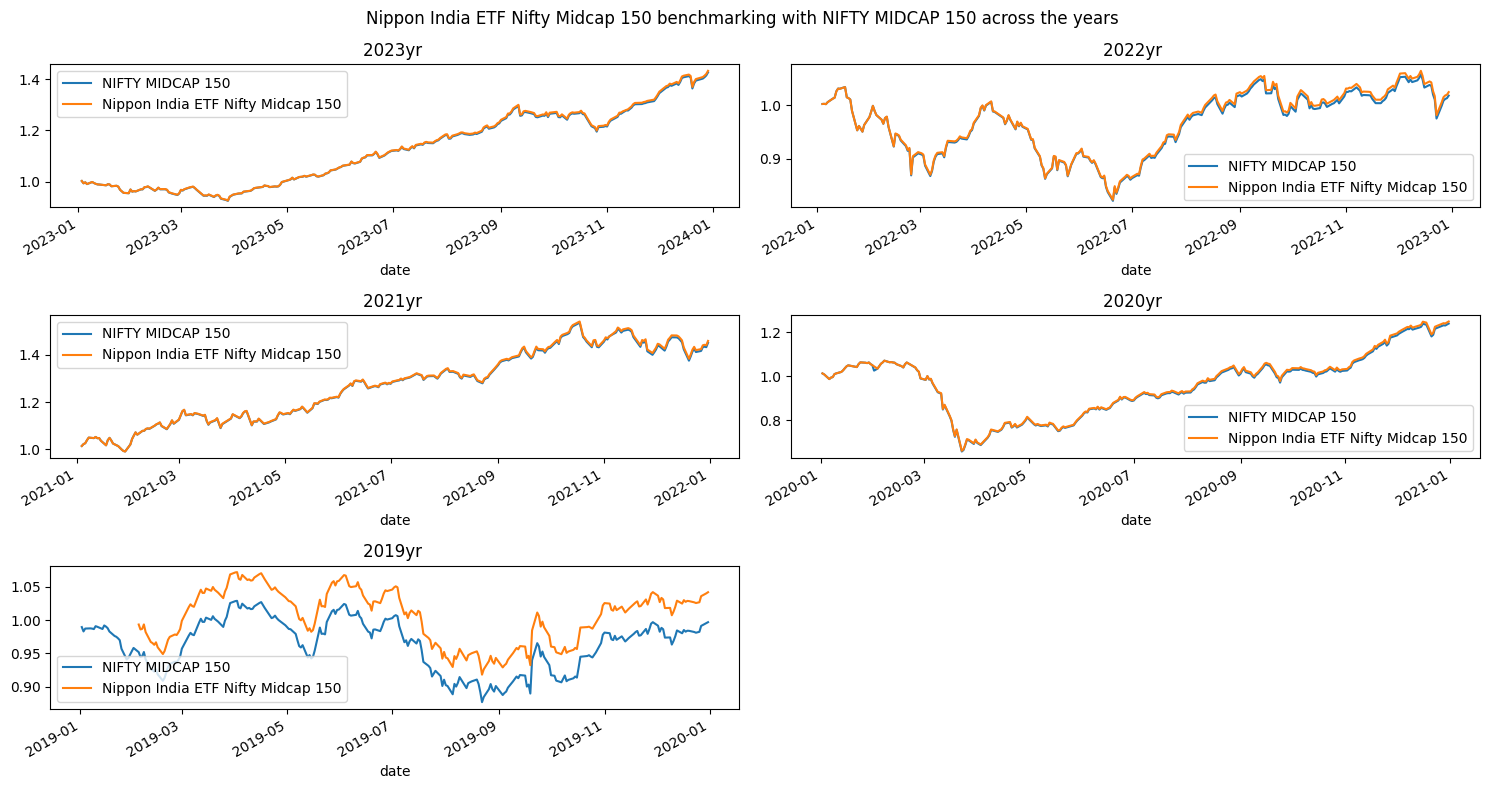

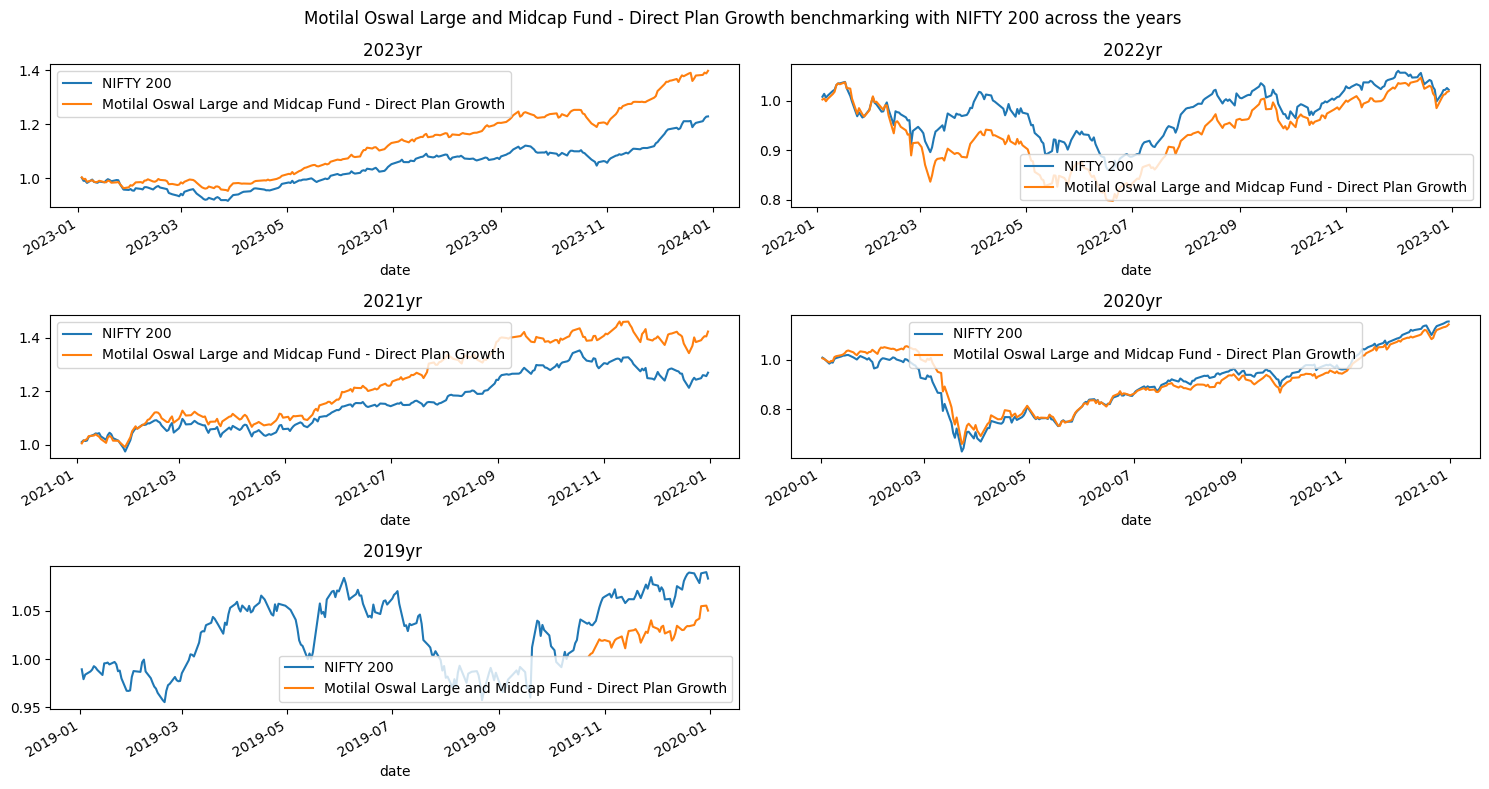

In [54]:
for fund, index in funds_benchmark_mapping.items():
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 8))

    # Flatten the axes array for easy indexing
    axes = axes.flatten()
    
    for ax in axes:
        ax.set_axis_off()

#     for i, time_period in enumerate([1,2,3,4]):
    for i, time_period in enumerate(list(time_periods)):
        index_df = time_period_nifty_dataframes[time_period][index].copy()
        fund_df = time_period_dataframes[time_period][fund].copy()

        # Use the current subplot
        ax = axes[i]
        ax.set_axis_on()

        # Plot on the current subplot
        index_df.plot(ax=ax, y='cumulative_daily_returns', x='date', label=index)
        fund_df.plot(ax=ax, y='cumulative_daily_returns', x='date', label=fund)

        ax.set_title(f'{time_period}yr ')

    # Adjust layout for better spacing
    plt.suptitle(f'{fund} benchmarking with {index} across the years ')
    plt.tight_layout()
    plt.show()

### Some questions: 

Analysis: Part 1 - Calculating returns for each year
1. How about each year analysis? i.e. just 2019 or just 2021. Compare fund vs benchmark 2019-01-01 to 2019-12-31, 2020-01-01 to 2020-12-31 etc
2. How many times was the fund able to beat the benchmark? 
3. WHat are one-year returns across multiple years for each fund? 
4. Has the performance of each fund increased YoY or has the performance deteriorated? 

Analysis: Part 2 - Calculating cumulative returns and CAGR 
1. Compare Fund vs benchmark at different year levels using the cumulative returns graph
2. Compare CAGR across a 3-yr period. Has the fund been able to beat the benchmark in terms of CAGR?

### Scenario builder 

1. 

In [28]:
import plotly.express as px
df = px.data.stocks()
fig = px.line(df, x="date", y=df.columns,
              hover_data={"date": "|%B %d, %Y"},
              title='custom tick labels with ticklabelmode="period"')
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y",
    ticklabelmode="period")
fig.show()